# The demonstration of the tropical precipitation module in detailes

# Structure


 1. [Load of](#1-load-of-packages-modules-and-data)

    1.1. [packages](#11-loading-the-necessary-packages)

    1.2. [modules and](#12-loading-the-written-modules)

    1.3. [data with the use of aqua package](#13-loading-the-data-with-the-use-of-aqua-package)

2. [Initialization of precipitation diagnostic and setting the class attributes](#2-initializing-the-class-object-and-setting-the-class-attributes)

3. [Illustration of some preprocessing possibilities of precipitation diagnostic, such as](#3-illustation-of-some-preprocessing-possibilietes-of-precipitation-diagnostic)

    3.1. [Selection of tropical latitudes](#32-selection-of-tropical-latitudes)


4. [Calculation of histogram of precipitation/tropical precipitation](#4-calculation-of-histogram-of-precipitationtropicalprecipitation)

    4.1. [with manual data preprocessing](#41-diagnostic-with-manual-data-preprocessing)

    4.2 [automatic data preprocessing](#42-diagnostic-with-automatic-data-preprocessing)

    4.3. [with non uniform binning](#43-histogram-with-not-uniform-binning)
    
5. [Calculation time expectation for a total dataset](#5-expected-calculation-time-for-entire-dataset)
 
6. [Creation of graphics with a graphic module](#6-creation-of-graphics)

    6.1. [Creation of images](#61-images)
    
    6.2. [Creation of animation](#62-animation)

    6.3  [Creation of images of high and low resolution](#63-images-with-the-regrided-the-coordinates)

[Go to the end of file](#the-end)

#

## 1. Load of  packages, modules and data

### 1.1. Loading the necessary packages

In [2]:
#import dask
import re
import os
import importlib
import timeit
import sys
import numpy as np
#import xarray

#### Storing the absolute path of the current repository into the variable

In [3]:
with os.popen("pwd ") as f:
    _pwd = f.readline()

pwd = re.split(r'[\n]', _pwd)[0]

#### Setting the path to the diagnostic repository 

In [4]:
sys.path.append(str(pwd)+'/../')

import src.tr_pr_module
import src.time_functions
import src.graphic_creator
import src.slurm_job

### 1.2. Loading the written modules

#### Loading the tropical precipitation module

In [5]:
importlib.reload(src.tr_pr_module)
from  src.tr_pr_module import  xarray_attribute_update, data_size, TR_PR_Diagnostic

#### Loading the extra functions, which can be used in any diagnostic

In [6]:
importlib.reload(src.time_functions)
from  src.time_functions import time_interpreter, estimated_total_calc_time, optimal_amount_of_timesteps, time_regrider

importlib.reload(src.graphic_creator)
from src.graphic_creator import  animation_creator, image_creator, lon_lat_regrider

importlib.reload(src.slurm_job)
from  src.slurm_job import  slurm_interactive_job, squeue_user, scancel

In [ ]:
slurm_interactive_job()

In [10]:
squeue_user()

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           4779119   compute dask-wor  b382267 PD       0:00      1 (None)


0

#### Importing the aqua module

In [12]:
import aqua
from aqua import Reader
from aqua.reader import catalogue

In [13]:
configdir = '../../../config/'
diagname  = 'tr_pr'
machine   = 'levante'
catalogue(configdir=configdir)

levante:
  args:
    path: ../../../config//levante/catalog.yaml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


### 1.3. Loading the data with the use of aqua package

#### ICON data

In [14]:
reader = Reader(model="ICON", exp="ngc2009",  configdir=configdir, source="atm_2d_ml_R02B09", regrid="r200")
ICON = reader.retrieve()

In [18]:
ICON

<xarray.Dataset>
Dimensions:   (time: 37009, cell: 20971520)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20 ... 2022-03-01
Dimensions without coordinates: cell
Data variables: (12/33)
    cfh_lnd   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tciw      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tclw      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cptgzvi   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    mslhfl    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    msshfl    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ...        ...
    10u       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    10v       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    msntrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    mtntrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    msnsrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    mtnsrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 1522142023-04-17 18:18:14 retrie...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

#### Regriding the small part/chunk of dataset for tests

In [70]:
ICON_chunk_regrided = reader.regrid(ICON["tprate"][10:30,:])

In [20]:
ICON_chunk_regrided 

<xarray.DataArray 'tprate' (time: 20, lat: 90, lon: 180)>
dask.array<reshape, shape=(20, 90, 180), dtype=float64, chunksize=(6, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T05:00:00 ... 2020-01-20T14:30:00
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes: (12/16)
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    units:                        m s**-1
    ...                           ...
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1
    regridded:                    1

## 2. Initializing the class object and setting the class attributes

In [17]:
diag = TR_PR_Diagnostic()

diag.num_of_bins    = 15
diag.first_edge     = 0
diag.width_of_bin   = 1*10**(-4)/diag.num_of_bins
diag.bins           = None


diag.trop_lat = 10

# time related attributes 
diag.s_time     = None
diag.f_time     = None
diag.s_year     = None
diag.f_year     = None 
diag.s_month    = None
diag.f_month    = None 

#### User can put specify all attributes during initialization of class object 

In [44]:
diag = TR_PR_Diagnostic(num_of_bins = 20, first_edge = 0, width_of_bin = 1*10**(-6)/15)

#### Attributes of the class can be updated in two ways

In [81]:
print(diag.num_of_bins)
diag.num_of_bins = 30
print(diag.num_of_bins)

15
30


#### OR

In [82]:
print(diag.num_of_bins)
diag.class_attributes_update(num_of_bins = 20, first_edge = 0, width_of_bin = 1*10**(-6)/20)
print(diag.num_of_bins)

30
20


## 3. Illustration of some preprocessing possibilities of precipitation diagnostic

#### We may want to pass the attributes of entire dataset into our regrided chunk of data. (Also, sum the `history` of datasets) 

In [24]:
ICON_chunk_regrided = xarray_attribute_update(ICON_chunk_regrided, ICON)

#### Units of precepitation rate

In [27]:
ICON_chunk_regrided.attrs['units']

'm s**-1'

### 3.1 Selection of tropical latitudes

In [28]:
ICON_chunk_regrided = ICON_chunk_regrided.compute()
ICON_chunk_regrided_trop = diag.ds_per_lat_range(ICON_chunk_regrided)

In [ ]:
ICON_chunk_regrided_trop

#### We can modify the selected tropical area as 

In [ ]:
diag.trop_lat = 25

ICON_chunk_regrided_trop = diag.ds_per_lat_range(ICON_chunk_regrided)

#### OR 

In [91]:
ICON_chunk_regrided_trop = diag.ds_per_lat_range(ICON_chunk_regrided, trop_lat = 10)

## 4. Calculation of histogram of precipitation/tropicalprecipitation


### 4.1. Diagnostic with manual data preprocessing

### Fastest histogram

In [34]:
hist_ICON  = diag.hist1d_fast(ICON_chunk_regrided,  preprocess = False)
hist_ICON

<xarray.DataArray (bin: 20)>
array([2.92683e+05, 1.33590e+04, 5.97500e+03, 3.47900e+03, 2.15400e+03,
       1.54000e+03, 1.16200e+03, 8.14000e+02, 5.64000e+02, 4.74000e+02,
       3.37000e+02, 2.69000e+02, 2.17000e+02, 1.57000e+02, 1.46000e+02,
       1.18000e+02, 7.90000e+01, 8.00000e+01, 5.50000e+01, 5.60000e+01])
Coordinates:
  * bin      (bin) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
Attributes: (12/26)
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    units:                        m s**-1
    ...                           ...
    institution:                  Max Planck Institute for Meteorology/Deutsc...
    number_of_grid_used:          15
    references:                   see MPIM/DWD publications
    source:                       git@gitlab.dkrz.de:icon/icon-aes.git@87a1ea...
    title:                        ICON simulation
    uuidOfHGrid:                  0f1e7d66-637e-11e8-913b-51232bb4d8f9

#### Only for tropical area

In [35]:
hist_ICON_trop  = diag.hist1d_fast(ICON_chunk_regrided_trop,  preprocess = False)
hist_ICON_trop

<xarray.DataArray (bin: 20)>
array([2.9011e+04, 2.7370e+03, 1.4590e+03, 8.6600e+02, 5.4200e+02,
       3.9700e+02, 2.6000e+02, 2.0300e+02, 1.3500e+02, 1.0200e+02,
       8.0000e+01, 4.4000e+01, 3.0000e+01, 2.6000e+01, 1.9000e+01,
       1.4000e+01, 2.0000e+01, 1.3000e+01, 1.3000e+01, 9.0000e+00])
Coordinates:
  * bin      (bin) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
Attributes: (12/26)
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    units:                        m s**-1
    ...                           ...
    institution:                  Max Planck Institute for Meteorology/Deutsc...
    number_of_grid_used:          15
    references:                   see MPIM/DWD publications
    source:                       git@gitlab.dkrz.de:icon/icon-aes.git@87a1ea...
    title:                        ICON simulation
    uuidOfHGrid:                  0f1e7d66-637e-11e8-913b-51232bb4d8f9

## 4.2. Diagnostic with automatic data preprocessing

In [50]:
diag = TR_PR_Diagnostic()

# mandatory attributes
diag.num_of_bins = 15
diag.first_edge = 0
diag.width_of_bin = 1*10**(-4)/diag.num_of_bins

# other attributes of class whoch have a default value
diag.trop_lat = 10
diag.s_time = 10
diag.f_time = 20

#### OR

In [19]:
diag = TR_PR_Diagnostic(num_of_bins = 20, first_edge = 0, width_of_bin = 1*10**(-6)/15, s_time = 10, f_time = 20)

In [ ]:
ICON

In [36]:
hist_ICON_prepr  = diag.hist1d_fast(ICON, reader=reader, trop_lat = 10, s_time = 10,  f_time = 15)
hist_ICON_prepr 

<xarray.DataArray (bin: 20)>
array([7.538e+03, 5.180e+02, 2.980e+02, 1.920e+02, 1.200e+02, 1.020e+02,
       6.100e+01, 4.700e+01, 3.400e+01, 1.800e+01, 1.600e+01, 1.200e+01,
       1.000e+01, 1.100e+01, 5.000e+00, 7.000e+00, 7.000e+00, 1.000e+00,
       3.000e+00, 0.000e+00])
Coordinates:
  * bin      (bin) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
Attributes: (12/16)
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    units:                        m s**-1
    ...                           ...
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1
    regridded:                    1

In [15]:
hist_ICON_prepr  = diag.hist1d_fast(ICON, reader=reader, trop_lat = 10, s_month=3,  f_month=4)
hist_ICON_prepr 

In [ ]:
hist_ICON_prepr  = diag.hist1d_fast(ICON, reader=reader, trop_lat = 10,  s_time = '2020:01', f_time ='2020/03/20/12')
hist_ICON_prepr 

In [ ]:
hist_ICON_prepr  = diag.hist1d_fast(ICON, reader=reader, trop_lat = 10, s_time = '2020', f_time ='2020.03.20')
hist_ICON_prepr 

### 4.3. Histogram with not uniform binning

In [37]:
bins = np.logspace(-9, -6, 15)
bins

array([1.00000000e-09, 1.63789371e-09, 2.68269580e-09, 4.39397056e-09,
       7.19685673e-09, 1.17876863e-08, 1.93069773e-08, 3.16227766e-08,
       5.17947468e-08, 8.48342898e-08, 1.38949549e-07, 2.27584593e-07,
       3.72759372e-07, 6.10540230e-07, 1.00000000e-06])

In [38]:
diag = TR_PR_Diagnostic(bins = bins, s_time = 10, f_time = 80)

In [39]:
ICON_chunk_regrided_trop=ICON_chunk_regrided_trop.compute()

In [40]:
hist_ICON_trop_logspaced  = diag.hist1d_np(ICON_chunk_regrided_trop, preprocess=False, bins=bins)
hist_ICON_trop_logspaced

<xarray.DataArray (bin: 14)>
array([1197, 1335, 1459, 1534, 1553, 1597, 1751, 1855, 1885, 1964, 1721,
       1236,  769,  284])
Coordinates:
  * bin      (bin) float64 1e-09 1.638e-09 2.683e-09 ... 3.728e-07 6.105e-07
Attributes: (12/26)
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    units:                        m s**-1
    ...                           ...
    institution:                  Max Planck Institute for Meteorology/Deutsc...
    number_of_grid_used:          15
    references:                   see MPIM/DWD publications
    source:                       git@gitlab.dkrz.de:icon/icon-aes.git@87a1ea...
    title:                        ICON simulation
    uuidOfHGrid:                  0f1e7d66-637e-11e8-913b-51232bb4d8f9

In [41]:
hist_ICON_trop_logspaced   = diag.hist1d_fast(ICON_chunk_regrided_trop,  preprocess = False, bins=bins)
hist_ICON_trop_logspaced 

<xarray.DataArray (bin: 15)>
array([13293.,  2719.,  1435.,   862.,   538.,   398.,   259.,   201.,
         134.,   102.,    81.,    43.,    30.,    26.,    19.])
Coordinates:
  * bin      (bin) float64 1e-09 1.638e-09 2.683e-09 ... 6.105e-07 1e-06
Attributes: (12/26)
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    units:                        m s**-1
    ...                           ...
    institution:                  Max Planck Institute for Meteorology/Deutsc...
    number_of_grid_used:          15
    references:                   see MPIM/DWD publications
    source:                       git@gitlab.dkrz.de:icon/icon-aes.git@87a1ea...
    title:                        ICON simulation
    uuidOfHGrid:                  0f1e7d66-637e-11e8-913b-51232bb4d8f9

## 5. Expected calculation time for entire dataset

#### Timestep of dataset is

In [ ]:
time_interpreter(ICON)
time_interpreter(ICON_chunk_regrided) 

####  Checking the calculation time of a small chunk of the dataset

In [45]:
result = %timeit -r 2 -n 1 -o  diag.hist1d_fast(ICON_chunk_regrided_trop,  preprocess = False)
time_fast_reg, time_fast_reg_stdev =  result.average, result.stdev 

716 µs ± 81.3 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)


#### Estemated calculation time of entire dataset

In [46]:
estimated_total_calc_time(ds_part = ICON_chunk_regrided_trop, calc_time = time_fast_reg, ds_full = ICON,  units='D')

(15438.658136121961, 0.17868817287178196)

#### Optimal amount of timesteps

In [49]:
optimal_amount_of_timesteps(ds_part = ICON_chunk_regrided_trop, calc_time = time_fast_reg,  ds_full = ICON, wanted_time ='3H')

(0.6995426613360359, 25889)

#

## 6. Creation of graphics 

### 6.1. Images

#### Plot of obtained histogram 

#### We can make plots of frequency histograms. We need to set `pdf` argument in `hist_plot` function to `False` 

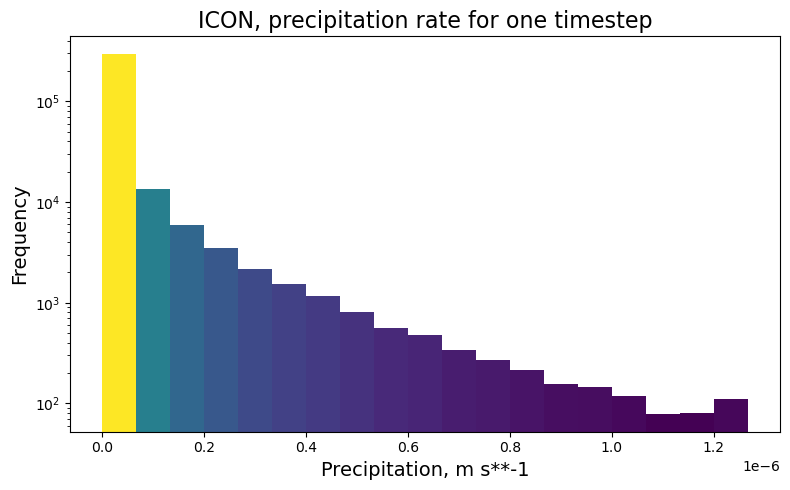

In [52]:
diag.hist_plot(hist_ICON, pdf = False, smooth = False, label='ICON/ICON', plot_title = "ICON, precipitation rate for one timestep")

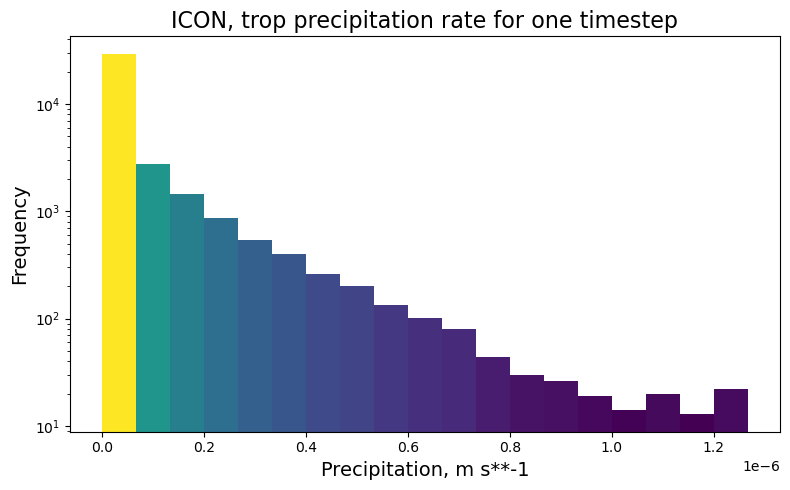

In [53]:
diag.hist_plot(hist_ICON_trop, pdf = False, smooth = False, label='ICON/ICON_trop', plot_title = "ICON, trop precipitation rate for one timestep")

#### Or we can create a pdf histogram by setting `pdf = True` in `hist_plot` function. (Default value of `pdf` is `True`)

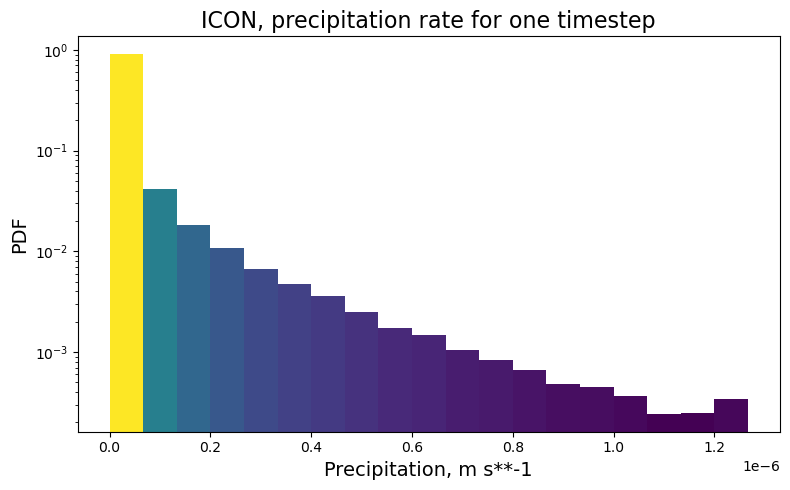

In [54]:
diag.hist_plot(hist_ICON, smooth = False, label='ICON/ICON', plot_title = "ICON, precipitation rate for one timestep")

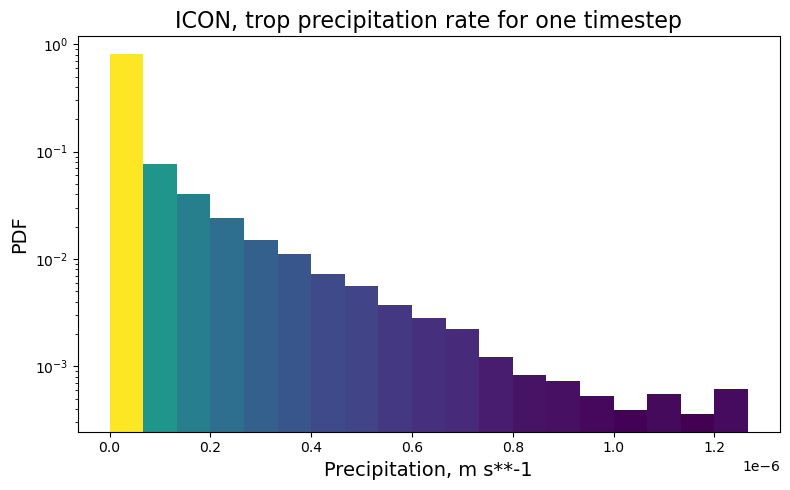

In [55]:
diag.hist_plot(hist_ICON_trop, pdf = True, smooth = False, label='ICON/ICON_trop', plot_title = "ICON, trop precipitation rate for one timestep")

#### We can also plot typical 2D dependence of counts versus the right edge of the bins by setting the `smooth = True.` It is also a default value.

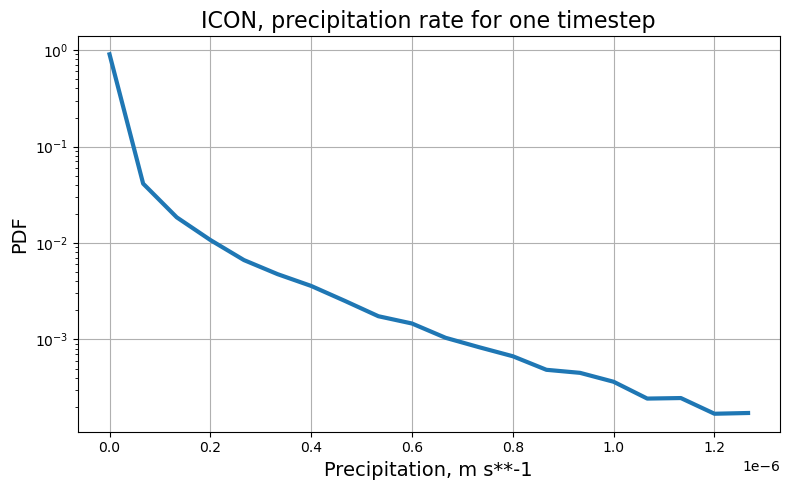

In [56]:
diag.hist_plot(hist_ICON, label='ICON/ICON', plot_title = "ICON, precipitation rate for one timestep")

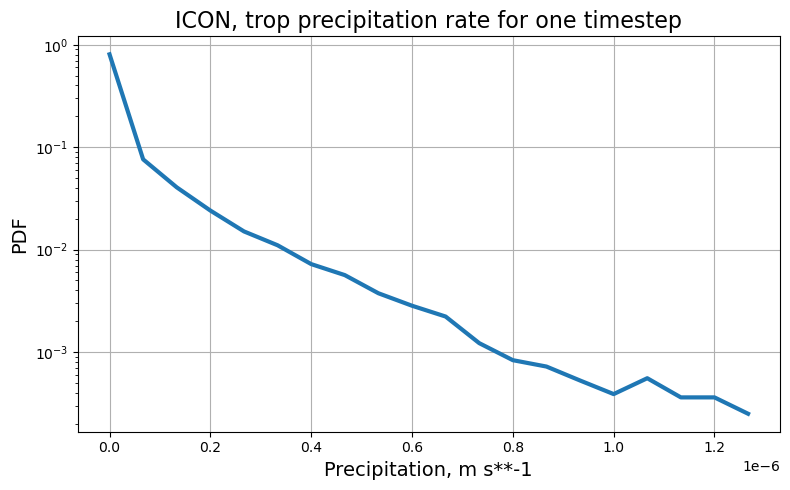

In [57]:
diag.hist_plot(hist_ICON_trop, pdf = True, smooth = True, label='ICON/ICON_trop', plot_title = "ICON, trop precipitation rate for one timestep")

### Histogram of logspaced binning. Argument `xlogscale=True` setting x-axe to the log scale. By default `xlogscale=False` 

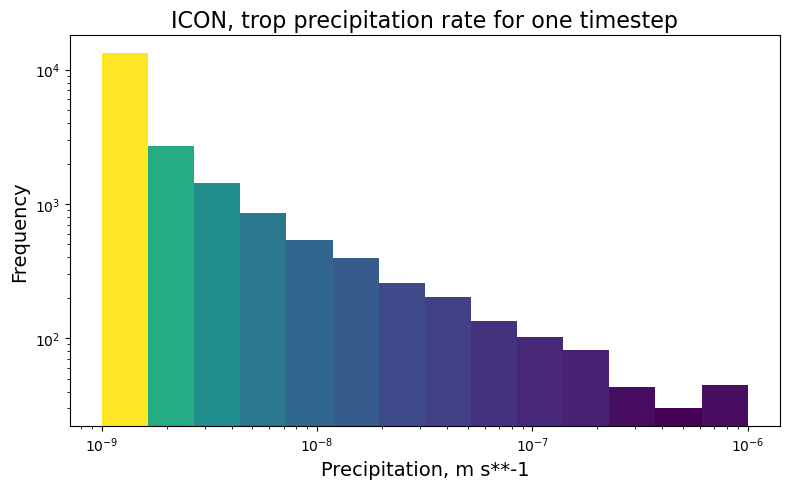

In [58]:
diag.hist_plot(hist_ICON_trop_logspaced, pdf = False, smooth = False, xlogscale=True, label='ICON/ICON_trop_log', plot_title = "ICON, trop precipitation rate for one timestep")

#### OR

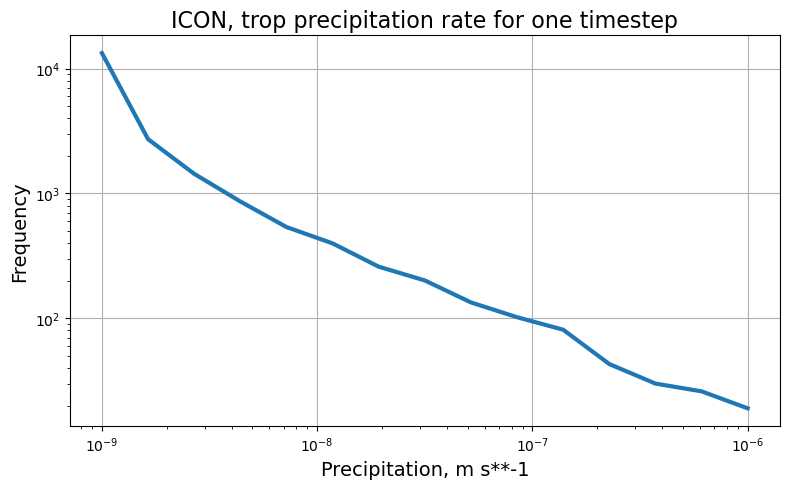

In [59]:
diag.hist_plot(hist_ICON_trop_logspaced, pdf = False, smooth = True, xlogscale=True, label='ICON/ICON_trop_log', plot_title = "ICON, trop precipitation rate for one timestep")

#### Plot of mean and median value of precipitation rate

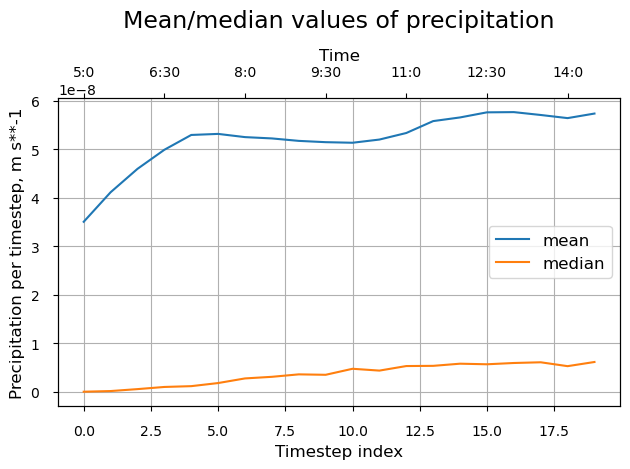

In [60]:
diag.mean_and_median_plot(ICON_chunk_regrided, savelabel = 'ICON/ICON')

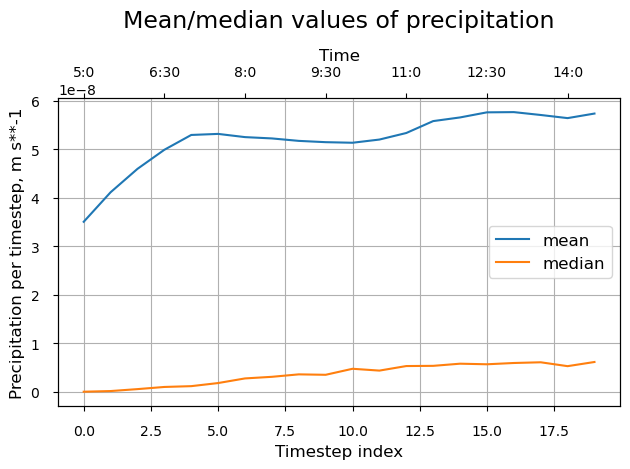

In [61]:
diag.mean_and_median_plot(ICON_chunk_regrided_trop, savelabel = 'ICON/ICON_trop')

#### Parameter plots

In [224]:
ICON_chunk_regrided = ICON_chunk_regrided.compute()

Done!


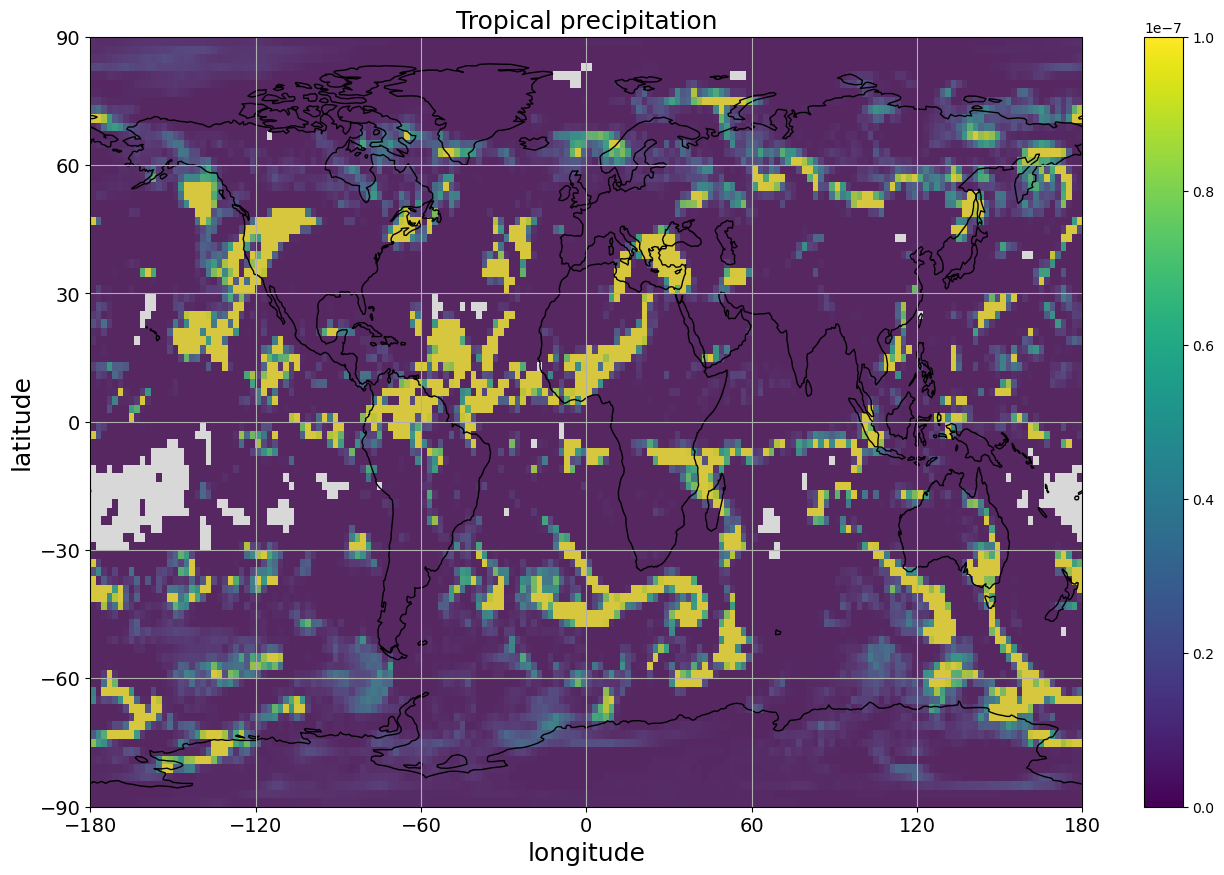

In [63]:
image_creator(ICON_chunk_regrided, vmin =0, vmax = 10**(-7),   figsize =2, trop_lat = 90,  label='ICON/ICON')

In [227]:
ICON_chunk_regrided_trop = ICON_chunk_regrided_trop.compute()

Done!


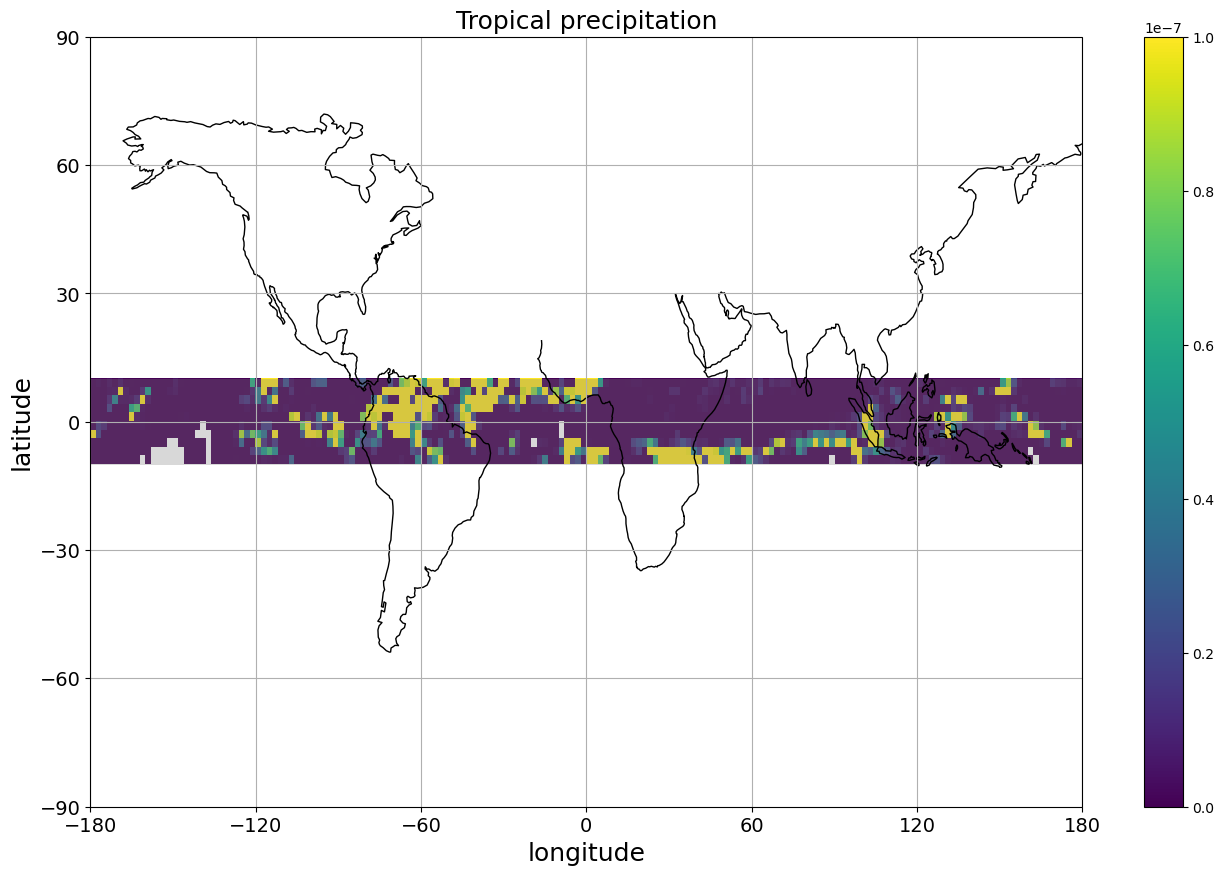

In [65]:
image_creator(ICON_chunk_regrided_trop, vmin =0, vmax = 10**(-7),  figsize =2, label='ICON/ICON_trop')

#

### 6.2. Animation

In [22]:
squeue_user()

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           4779119   compute dask-wor  b382267  R       2:31      1 l30561


0

In [24]:
ICON_chunk_regrided = reader.regrid(ICON["tprate"][10:100,:])
ICON_chunk_regrided = ICON_chunk_regrided.compute()

.............................................................Done!


True

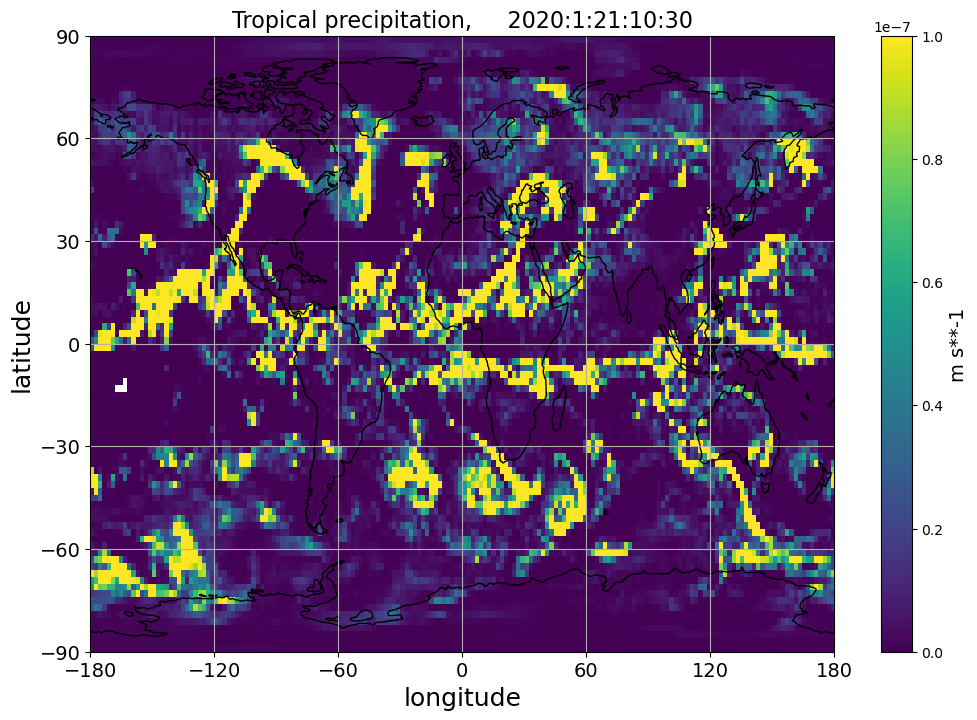

In [25]:
animation_creator(ICON_chunk_regrided, vmin =0, vmax = 10**(-7),   nSeconds = 60,  trop_lat = 90,  label='ICON_tprate')

In [20]:
ICON_chunk_regrided_trop = diag.ds_per_lat_range(ICON_chunk_regrided)
ICON_chunk_regrided_trop = ICON_chunk_regrided_trop.compute()

.....................Done!


True

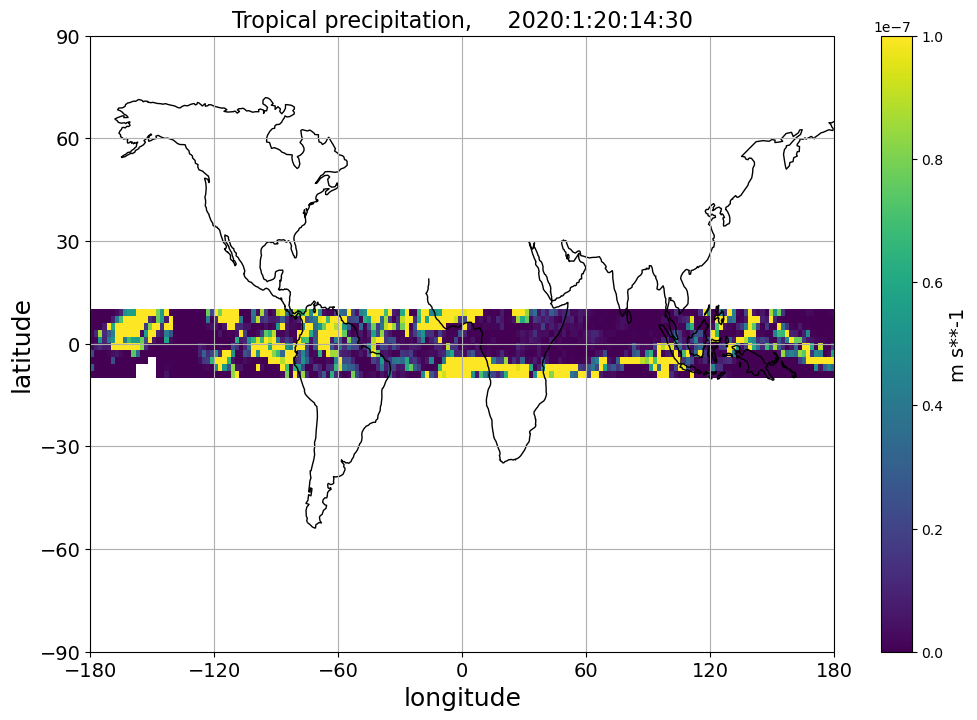

In [21]:
animation_creator(ICON_chunk_regrided_trop, vmin =0, vmax = 10**(-7), nSeconds = 20,  trop_lat = 10,  label='ICON_tprate_trop')

[Back to the top of file](#structure)

#

## 6.3 Images with the regrided the coordinates (high and low resolution)

### 6.3.1.Time regriding

In [ ]:
ICON_chunk_regrided_trop

In [ ]:
time_regrider(ICON_chunk_regrided_trop, timestep = -3)

In [ ]:
time_regrider(ICON_chunk_regrided_trop, new_time_unit='2H')

In [17]:
ICON_chunk_regrided = ICON_chunk_regrided.compute()

### 6.3.2 Space regriding

#### Data regriding into high resolution

In [73]:
lat_high_res    = lon_lat_regrider(ICON_chunk_regrided, step = 20, coord_name = 'lat')
latlon_high_res  = lon_lat_regrider(lat_high_res, step = 20, coord_name='lon')

#### Data regriding into low resolution

In [ ]:
lat_low_res    = lon_lat_regrider(ICON_chunk_regrided, step = -10, coord_name = 'lat')
latlon_low_res  = lon_lat_regrider(lat_low_res, step = -10, coord_name='lon')

#### Original resolution

Done!


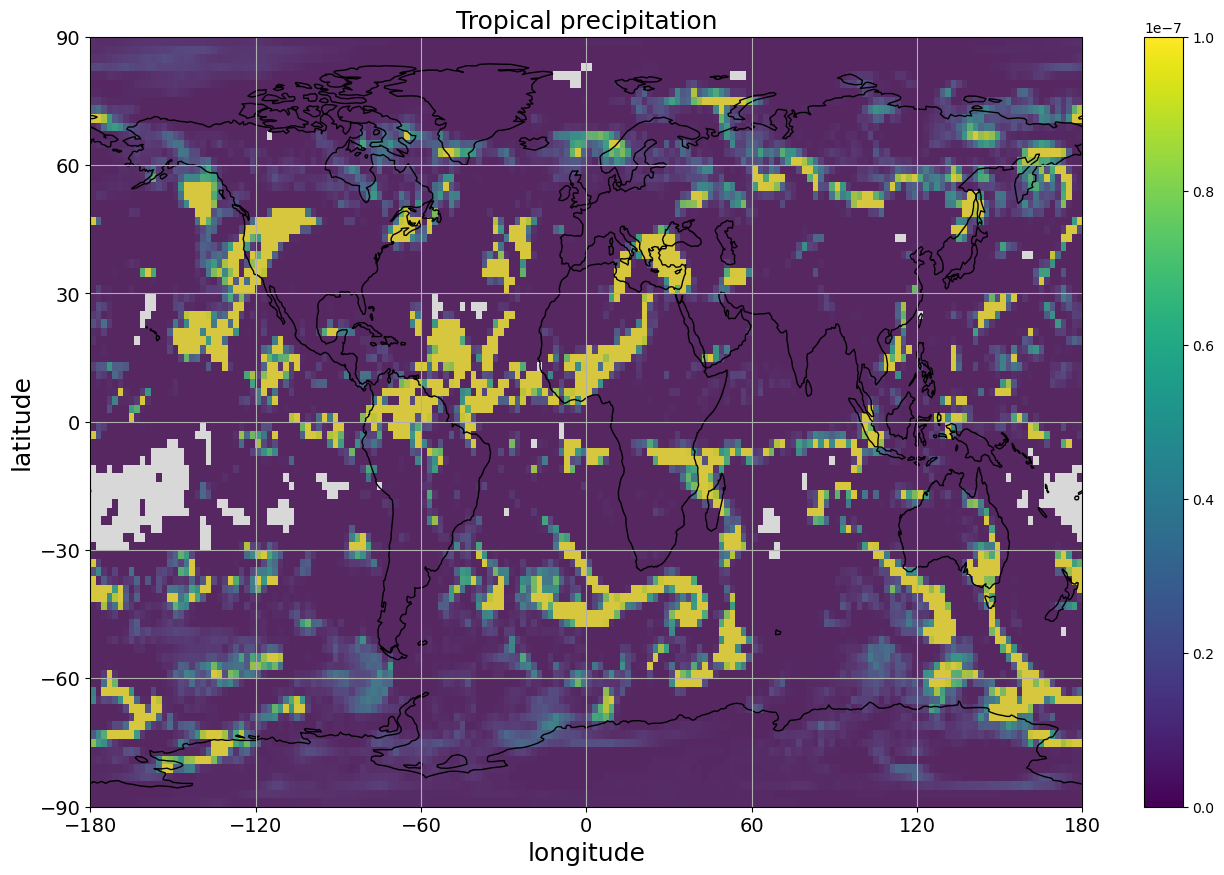

In [75]:
image_creator(ICON_chunk_regrided, vmin = 0, vmax = 10**(-7), figsize=2,  trop_lat = 90,  label='ICON/ICON_original')

#### High resolution

Done!


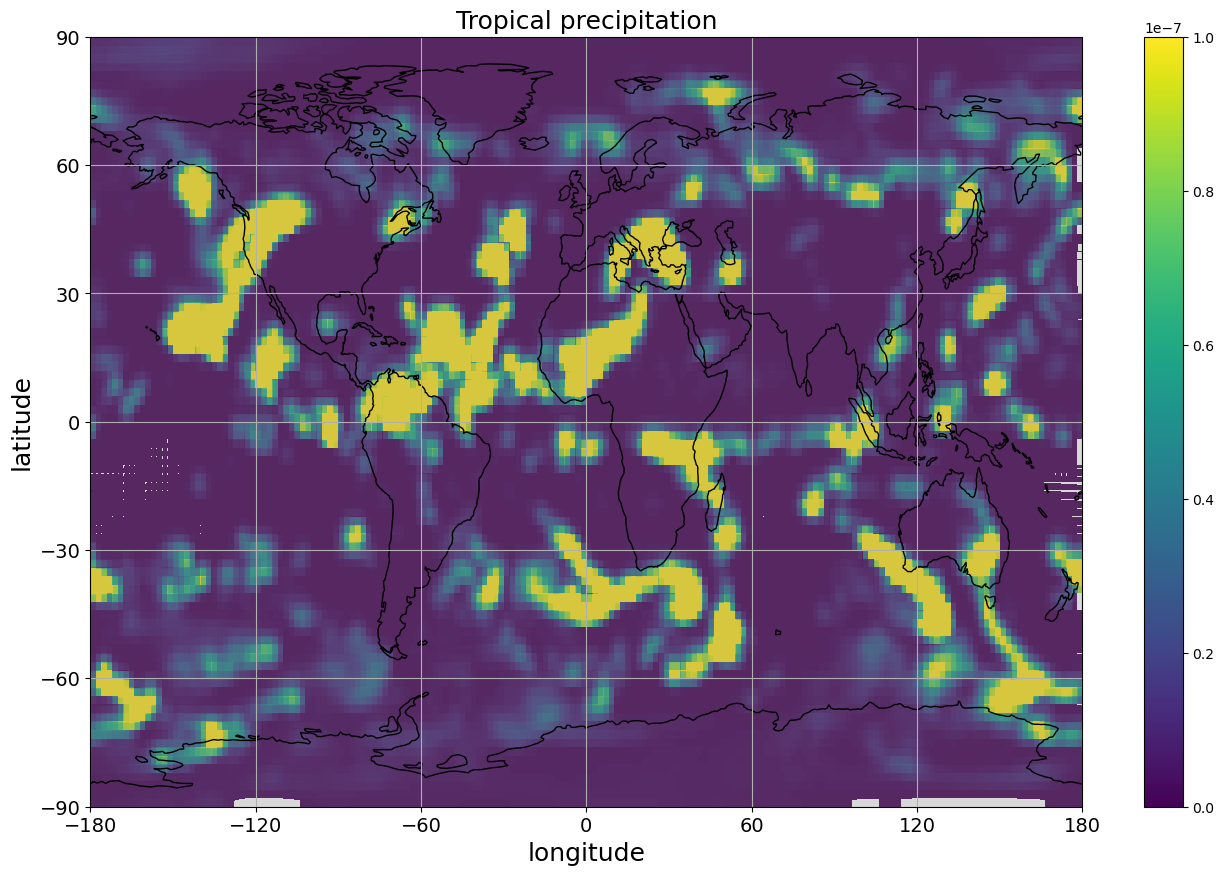

In [76]:
image_creator(latlon_high_res, vmin = 0, vmax = 10**(-7), figsize=2, trop_lat = 90,  label='ICON/ICON_regrided_highres') #

#### Low resolution

Done!


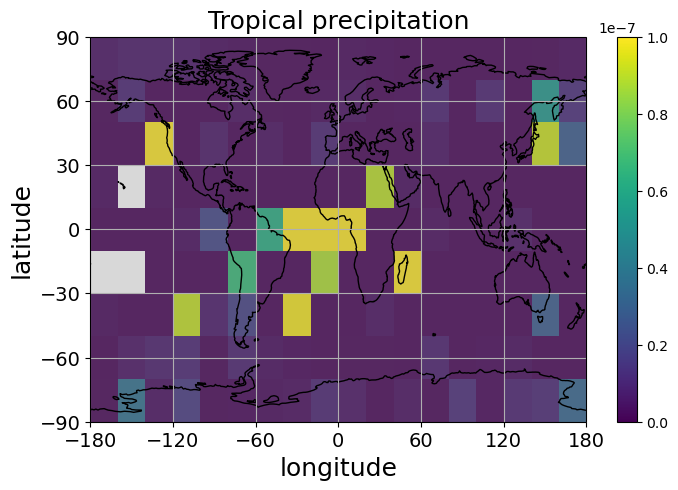

In [77]:
image_creator(latlon_low_res, vmin = 0, vmax = 10**(-7),  trop_lat = 90,  label='ICON/ICON_regrided_lowres') #

##### The end